In [110]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Defining the boundary/initial conditions

In [111]:
tmin = 0.0
tmax = 1.0
nt = 5000
t_0 = tf.zeros((1,1), dtype='float32')
t_pts = tf.random.uniform((nt,1), tmin, tmax, dtype='float32')

In [112]:
t_0

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>

### Define the residual function for training

In [113]:
def residual(t,x,x_t):
    return x_t + x

x_0 = tf.ones((1,1), dtype='float32')*5.0 #initial condition

### Define training model and loss function. 

In [114]:
def init_model(num_hidden_layers, num_array):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    model.add(tf.keras.Input(1))

    #scaling_layer = tf.keras.layers.Lambda(
    #            lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    #model.add(scaling_layer)

    # Append hidden layers
    for i in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_array[i],
            activation=tf.keras.activations.get('relu'),
            kernel_initializer='he_uniform'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))
    
    return model

In [115]:
def find_res(model, t):
    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t) 
        x = model(t)
            
    x_t = tape.gradient(x, t)

    del tape

    return residual(t, x, x_t)

In [116]:
def loss_func(model, t_pts, t_0):
    
    lf = find_res(model, t_pts)
    L_res = tf.reduce_mean(tf.square(lf))
    
    init_pred = model(t_0)
    L_init = tf.reduce_mean(tf.square(x_0 - init_pred))
    
    loss_tot = L_res + L_init
    
    return loss_tot

In [117]:
def gradient_loss(model, t_pts, t_0):
    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(model.trainable_variables)
        loss = loss_func(model, t_pts, t_0)

    grad = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, grad

### Model initialization and training

In [118]:
model = init_model(4,[32,32,16,8])

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([100],[1e-2,1e-3])

optim = tf.keras.optimizers.Adam(learning_rate=lr)

In [119]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = gradient_loss(model, t_pts, t_0)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    
    return loss

# Number of training epochs
N = 500
hist = []

# Start timer
t0 = time()

for i in range(N+1):
    
    loss = train_step()
    
    # Append current loss to hist
    hist.append(loss.numpy())
    
    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))
        
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 2.58869305e+01
It 00050: loss = 8.53749275e-01
It 00100: loss = 1.32722795e-01
It 00150: loss = 1.01530515e-01
It 00200: loss = 8.92433152e-02
It 00250: loss = 7.82765970e-02
It 00300: loss = 7.33101815e-02
It 00350: loss = 6.62090704e-02
It 00400: loss = 5.82147837e-02
It 00450: loss = 5.03975376e-02
It 00500: loss = 4.42422591e-02

Computation time: 6.81104302406311 seconds


In [120]:
t_0

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>

In [124]:
t_test = np.linspace(tmin,tmax,100)
x_pred = model(tf.cast(t_test,'float32'))

In [125]:
x_plt = np.reshape(x_pred.numpy(),(100,))
x_actual = 5.0*np.exp(-1.0*t_test)

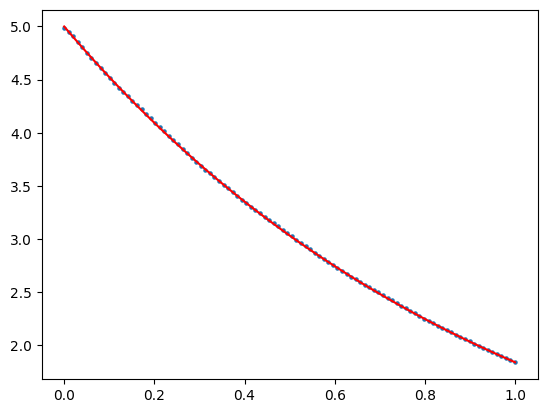

In [128]:
plt.scatter(t_test,x_pred,s=5)
plt.plot(t_test,x_actual,c='r')